# Radial basis function network

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import sklearn.cluster as cluster
import sklearn.datasets as ds
import seaborn as sns

# Prettier plots
sns.set()

In [2]:
def make_moons_parametrized(n_samples, radius, width, d, **kwargs):
    # 1 sample consists of a pair of A and B
    n_samples *= 2 
    
    # Get moons 
    moons, inds = ds.make_moons(n_samples, shuffle = False, noise = kwargs.get("noise"))
        
    # Extract moons
    moon_a = moons[inds == 0]
    moon_b = moons[inds == 1]

    # Move moon B to origin
    moon_b[:,0] -= 1
    moon_b[:,1] -= 0.5

    # Apply radius and width
    moon_a *= radius
    moon_a *= np.random.uniform((radius - width/2)/radius, (radius + width/2)/radius, moon_a.shape)
    moon_b *= radius
    moon_b *= np.random.uniform((radius - width/2)/radius, (radius + width/2)/radius, moon_b.shape)

    # Move moon B back
    moon_b[:,0] += radius
    moon_b[:,1] -= d
    
    moons = np.append(moon_a, moon_b, 0)
    
    # Shuffle dataset, assumes inds is unshuffled (neccessary?)
    rng_state = np.random.get_state()
    np.random.shuffle(moons)
    np.random.set_state(rng_state)
    np.random.shuffle(inds)
    
    return moons, inds

In [3]:
# Constant parameters
radius = 10
width = 6
n_samples = 1000
n_clusters = 6
d_range = (-1, 0, 1, 2, 3, 4, 5, 6)

Distance = -1

Distance = 0

Distance = 1

Distance = 2

Distance = 3

Distance = 4

Distance = 5

Distance = 6



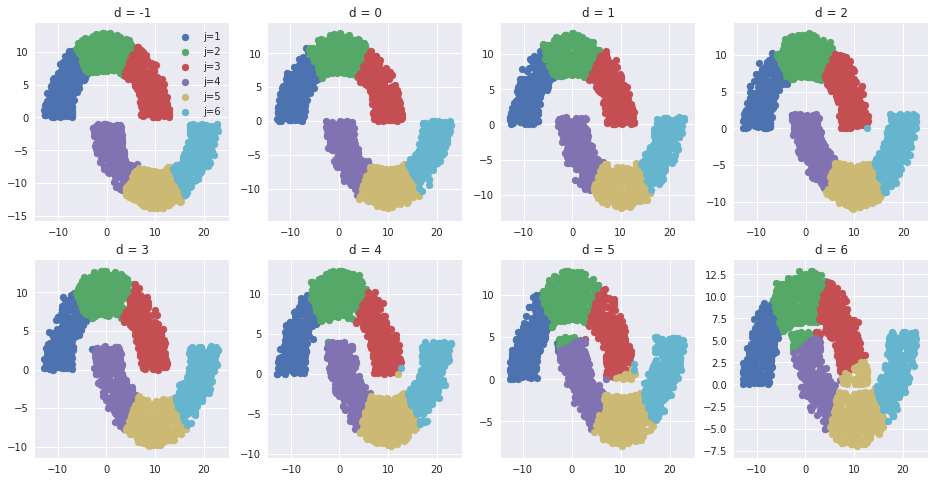

In [4]:
np.random.seed(0)

means = []
variances = []

fig, arr = plt.subplots(2,4, figsize=(16,8))

for di, d in enumerate(d_range):
    print("Distance = " + str(d))
    moons, inds = make_moons_parametrized(n_samples, radius, width, -d)
    
    # Set initial centers of the clusters
    initial_centers = np.array([[-10, 5],[0, 10],[8, 5], [0, -5], [10, -10], [18, -8]])
    kmeans = cluster.KMeans(n_clusters=n_clusters, init=initial_centers, n_init=1).fit(moons)
    
    means_cluster = []
    variances_cluster = []
    
    arr[np.unravel_index(di, arr.shape)].set_title("d = " + str(d))
    
    for i in range(n_clusters):
        m = moons[kmeans.labels_==i]
        arr[np.unravel_index(di, arr.shape)].scatter(m[:,0], m[:,1], label="j="+str(i+1))
        mean = np.mean(m, 0)
        means_cluster.append(mean)
        # According to Equation (5.27)
        variance = np.sum(np.linalg.norm(m - mean, axis=1)**2)/n_samples
        #variance = np.var(m)
        variances_cluster.append(variance)
        #print("Mean for cluster " + str(i + 1) + ": " + str(mean))
        #print("Variance for cluster " + str(i + 1) + ": " + str(variance))
    
    means.append(np.array(means_cluster))
    variances.append(np.array(variances_cluster))
    print()

arr[0,0].legend()
plt.show()
    
means = np.array(means)
variances = np.array(variances);

In [5]:
print("Change of j = 1 " + str(means[-1,0] - means[0,0]))
print("Change of j = 2 " + str(means[-1,1] - means[0,1]))
print("Change of j = 3 " + str(means[-1,2] - means[0,2]))

Change of j = 1 [-0.42600479 -0.44200805]
Change of j = 2 [-1.25762895 -0.64040253]
Change of j = 3 [-1.1361656   1.43519418]


The effects of reducing $d$ are as follows:

- $j=1$ was shifted a little bit the the left and down, but was overall affected the least

- $j=2$ was shifted to the left and down by incorporating some of the points of the nearing moon

- $j=3$ was shifted to the left by enclosing some of the points j=2 lost and up by losing points to j=5


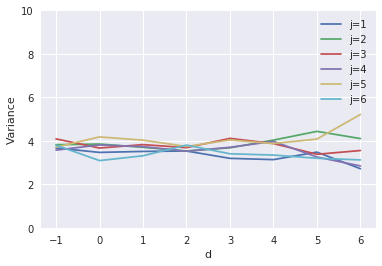

In [6]:
for i in range(n_clusters):
    plt.plot(d_range, variances[:,i], label="j="+str(i+1))
plt.legend()
plt.xlabel("d")
plt.ylabel("Variance")
plt.ylim((0, 10))
plt.show()

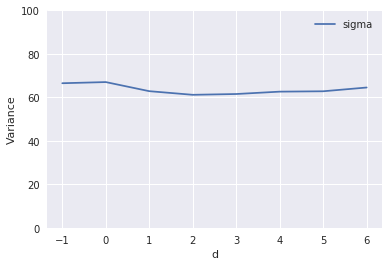

In [7]:
sigmas = []
for d in (1, 0, -1, -2, -3, -4, -5, -6):
    v = []
    for i in range(n_clusters):
        for j in range(n_clusters):
            v.append(np.linalg.norm(means[d][i] - means[d][j]))
    dmax = np.max(v)
    # According to Equation (5.49)
    sigma = dmax/np.sqrt(2*n_clusters)
    sigmas.append(sigma)
plt.plot(d_range, np.array(sigmas)**2, label="sigma")
plt.xlabel("d")
plt.ylabel("Variance")
plt.legend()
plt.ylim((0,100))
plt.show()

In [8]:
class RadialBasisFunctionNetwork:
    def __init__(self, n_inputs, n_hidden, n_output):
        self.centers = np.array([np.random.uniform(-1, 1, n_inputs) for i in range(n_hidden)])
        self.weights = np.random.random((n_hidden, n_output))

    def train(self, training_set_inputs, training_set_outputs):
        # Step 1 adjust centers with kmeans
        # cluster the data
        kmeans = cluster.KMeans(n_clusters=self.centers.shape[0], init=self.centers, n_init=1).fit(training_set_inputs)
        for c in range(self.centers.shape[0]):
            # update centers based on clusters
            m = training_set_inputs[kmeans.labels_==c]
            self.centers[c] = np.mean(m, 0)
        
        # Step 2 adjust weights with least squares algorithm
        hiddenOutputs = self.activate(training_set_inputs)
        self.weights, _, _, _ = np.linalg.lstsq(hiddenOutputs, training_set_outputs)
        
        return np.mean(np.abs(training_set_outputs - self.predict(training_set_inputs)))
        
    def radial_basis_function(self, current, center):
        return np.exp(-np.linalg.norm(current - center)**2)  # Gaussian
    
    def activate(self, inputs):
        hidden_outputs = np.zeros((inputs.shape[0], self.centers.shape[0]))
        for center, ci in zip(self.centers, range(self.centers.shape[0])):
            for inp, ii in zip(inputs, range(inputs.shape[0])):
                hidden_outputs[ii,ci] = self.radial_basis_function(inp, center)
        return hidden_outputs
    
    def predict(self, inputs):
        hidden_outputs = self.activate(inputs)
        outputs = np.dot(hidden_outputs, self.weights)
        return outputs

### 1) $1/x$

In [9]:
# Set up data
n_training_samples = 1000
n_test_samples = 2000

training_set_inputs = np.random.uniform(1, 100, (n_training_samples, 1))
training_set_outputs = 1/training_set_inputs

test_set_inputs = np.random.uniform(1, 100, (n_test_samples, 1))
test_set_outputs = 1/test_set_inputs

n_max_hidden_neurons = 10

In [10]:
rbfns = []

for n in range(1, n_max_hidden_neurons+1):
    rbfn = RadialBasisFunctionNetwork(1, n, 1)
    rbfns.append(rbfn)
    err = rbfn.train(training_set_inputs, training_set_outputs)
    print("Training error of RBFN with " + str(n) + " hidden neurons:", err)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Training error of RBFN with 1 hidden neurons: 0.044095693222760815
Training error of RBFN with 2 hidden neurons: 0.04338965158530871
Training error of RBFN with 3 hidden neurons: 0.042951480047165515
Training error of RBFN with 4 hidden neurons: 0.04183019888327555
Training error of RBFN with 5 hidden neurons: 0.04129520077534498
Training error of RBFN with 6 hidden neurons: 0.04066899968565576
Training error of RBFN with 7 hidden neurons: 0.04039569461282419
Training error of RBFN with 8 hidden neurons: 0.03933435268962552
Training error of RBFN with 9 hidden neurons: 0.0388881735440025
Training error of RBFN with 10 hidden neurons: 0.038828958780074134


In [11]:
for n in range(n_max_hidden_neurons):
    outputs = rbfns[n].predict(test_set_inputs)
    print("Test error of RBFN with " + str(n+1) + " hidden neurons:", np.mean(np.abs(outputs - test_set_outputs)))

Test error of RBFN with 1 hidden neurons: 0.047932836370474546
Test error of RBFN with 2 hidden neurons: 0.047306711364678476
Test error of RBFN with 3 hidden neurons: 0.04679206957362736
Test error of RBFN with 4 hidden neurons: 0.046216274437245526
Test error of RBFN with 5 hidden neurons: 0.045289105807378056
Test error of RBFN with 6 hidden neurons: 0.04428061922977489
Test error of RBFN with 7 hidden neurons: 0.04419121674025873
Test error of RBFN with 8 hidden neurons: 0.0437417006666396
Test error of RBFN with 9 hidden neurons: 0.043442359549417636
Test error of RBFN with 10 hidden neurons: 0.04311843467191141


### 2) $log_{10}(x)$

In [12]:
# Set up data
n_training_samples = 1000
n_test_samples = 2000

training_set_inputs = np.random.uniform(1, 10, (n_training_samples, 1))
training_set_outputs = np.log10(training_set_inputs)

test_set_inputs = np.random.uniform(1, 10, (n_test_samples, 1))
test_set_outputs = np.log10(test_set_inputs)

In [13]:
rbfns = []

for n in range(1, n_max_hidden_neurons+1):
    rbfn = RadialBasisFunctionNetwork(1, n, 1)
    rbfns.append(rbfn)
    err = rbfn.train(training_set_inputs, training_set_outputs)
    print("Training error of RBFN with " + str(n) + " hidden neurons:", err)

Training error of RBFN with 1 hidden neurons: 0.5361090740291624
Training error of RBFN with 2 hidden neurons: 0.37642479594438477


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Training error of RBFN with 3 hidden neurons: 0.2496571508840592
Training error of RBFN with 4 hidden neurons: 0.1345516133564085
Training error of RBFN with 5 hidden neurons: 0.07335180889547034
Training error of RBFN with 6 hidden neurons: 0.037134932879359366
Training error of RBFN with 7 hidden neurons: 0.03045523472060305
Training error of RBFN with 8 hidden neurons: 0.022841055128257286
Training error of RBFN with 9 hidden neurons: 0.014027628998754399
Training error of RBFN with 10 hidden neurons: 0.008851029663381407


In [14]:
for n in range(n_max_hidden_neurons):
    outputs = rbfns[n].predict(test_set_inputs)
    print("Test error of RBFN with " + str(n+1) + " hidden neurons:", np.mean(np.abs(outputs - test_set_outputs)))

Test error of RBFN with 1 hidden neurons: 0.5270470229320924
Test error of RBFN with 2 hidden neurons: 0.3797371306337424
Test error of RBFN with 3 hidden neurons: 0.2525637124095106
Test error of RBFN with 4 hidden neurons: 0.14037799512896998
Test error of RBFN with 5 hidden neurons: 0.0781761853658505
Test error of RBFN with 6 hidden neurons: 0.038866713765434976
Test error of RBFN with 7 hidden neurons: 0.031850887858833936
Test error of RBFN with 8 hidden neurons: 0.022977991541661903
Test error of RBFN with 9 hidden neurons: 0.014724669254552639
Test error of RBFN with 10 hidden neurons: 0.009624808110846964


### 3) $exp(-x)$

In [15]:
# Set up data
n_training_samples = 1000
n_test_samples = 2000

training_set_inputs = np.random.uniform(1, 10, (n_training_samples, 1))
training_set_outputs = np.exp(-training_set_inputs)

test_set_inputs = np.random.uniform(1, 10, (n_test_samples, 1))
test_set_outputs = np.exp(-test_set_inputs)

In [16]:
rbfns = []

for n in range(1, n_max_hidden_neurons+1):
    rbfn = RadialBasisFunctionNetwork(1, n, 1)
    rbfns.append(rbfn)
    err = rbfn.train(training_set_inputs, training_set_outputs)
    print("Training error of RBFN with " + str(n) + " hidden neurons:", err)

Training error of RBFN with 1 hidden neurons: 0.04220212435170065
Training error of RBFN with 2 hidden neurons: 0.036384667645232835


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Training error of RBFN with 3 hidden neurons: 0.028993723593828975
Training error of RBFN with 4 hidden neurons: 0.021956031556675103
Training error of RBFN with 5 hidden neurons: 0.02189853374640331
Training error of RBFN with 6 hidden neurons: 0.020100683342037882
Training error of RBFN with 7 hidden neurons: 0.014474943421512886
Training error of RBFN with 8 hidden neurons: 0.0144972194733148
Training error of RBFN with 9 hidden neurons: 0.01196705674900653
Training error of RBFN with 10 hidden neurons: 0.011938423360106587


In [17]:
for n in range(n_max_hidden_neurons):
    outputs = rbfns[n].predict(test_set_inputs)
    print("Test error of RBFN with " + str(n+1) + " hidden neurons:", np.mean(np.abs(outputs - test_set_outputs)))

Test error of RBFN with 1 hidden neurons: 0.03924938565419464
Test error of RBFN with 2 hidden neurons: 0.03461282927565774
Test error of RBFN with 3 hidden neurons: 0.02702123253087989
Test error of RBFN with 4 hidden neurons: 0.019581600219392578
Test error of RBFN with 5 hidden neurons: 0.019537365475053567
Test error of RBFN with 6 hidden neurons: 0.018062490616701406
Test error of RBFN with 7 hidden neurons: 0.013853633657412776
Test error of RBFN with 8 hidden neurons: 0.013847683709084058
Test error of RBFN with 9 hidden neurons: 0.011758903078888973
Test error of RBFN with 10 hidden neurons: 0.011732704893467873


### 4) $sin(x)$

In [18]:
# Set up data
n_training_samples = 1000
n_test_samples = 2000

training_set_inputs = np.random.uniform(1, np.pi/2, (n_training_samples, 1))
training_set_outputs = np.sin(training_set_inputs)

test_set_inputs = np.random.uniform(1, np.pi/2, (n_test_samples, 1))
test_set_outputs = np.sin(test_set_inputs)

In [19]:
rbfns = []

for n in range(1, n_max_hidden_neurons+1):
    rbfn = RadialBasisFunctionNetwork(1, n, 1)
    rbfns.append(rbfn)
    err = rbfn.train(training_set_inputs, training_set_outputs)
    print("Training error of RBFN with " + str(n) + " hidden neurons:", err)

Training error of RBFN with 1 hidden neurons: 0.04050710787136964
Training error of RBFN with 2 hidden neurons: 0.008960802271776412


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Training error of RBFN with 3 hidden neurons: 0.0006332821497225802
Training error of RBFN with 4 hidden neurons: 9.626147537602492e-06
Training error of RBFN with 5 hidden neurons: 5.535476336277378e-06
Training error of RBFN with 6 hidden neurons: 4.007081962604797e-07
Training error of RBFN with 7 hidden neurons: 3.4487889789769356e-08
Training error of RBFN with 8 hidden neurons: 4.096101559936116e-09
Training error of RBFN with 9 hidden neurons: 4.083515677599792e-09
Training error of RBFN with 10 hidden neurons: 3.891647122777897e-09


In [20]:
for n in range(n_max_hidden_neurons):
    outputs = rbfns[n].predict(test_set_inputs)
    print("Test error of RBFN with " + str(n+1) + " hidden neurons:", np.mean(np.abs(outputs - test_set_outputs)))

Test error of RBFN with 1 hidden neurons: 0.040718416097076146
Test error of RBFN with 2 hidden neurons: 0.008706225115392673
Test error of RBFN with 3 hidden neurons: 0.0006556590565065988
Test error of RBFN with 4 hidden neurons: 9.548388219831839e-06
Test error of RBFN with 5 hidden neurons: 5.75276147689352e-06
Test error of RBFN with 6 hidden neurons: 4.1656270739098834e-07
Test error of RBFN with 7 hidden neurons: 3.5417634566825563e-08
Test error of RBFN with 8 hidden neurons: 4.187872127414671e-09
Test error of RBFN with 9 hidden neurons: 4.194949286828731e-09
Test error of RBFN with 10 hidden neurons: 4.007031467967437e-09
